In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import torch
import torch.backends.cudnn as cudnn
import random
import numpy as np

# seeds
seed = 88
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset

# remove copyright banner
class RemoveCopyrightBanner(object):
    def __call__(self, img):
        width, height = img.size
        return img.crop((0, 0, width, height - 20))

transform = transforms.Compose([
    RemoveCopyrightBanner(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

granularity = 'variant'

# # Create the FGVC Aircraft dataset instance
# train_dataset = FGVCAircraft(
#     root='./data',
#     split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
#     annotation_level=granularity,    # Options: 'variant', 'family', 'manufacturer'
#     transform=transform,
#     download=True
# )

data_root = './data'

train_dataset = datasets.FGVCAircraft(
    root=data_root,
    split='train',
    annotation_level=granularity,
    download=True,
    transform=transform
)

val_dataset = datasets.FGVCAircraft(
    root=data_root,
    split='val',
    annotation_level=granularity,
    download=True,
    transform=transform
)
test_dataset = datasets.FGVCAircraft(
    root=data_root,
    split='test',
    annotation_level=granularity,
    download=True,
    transform=transform
)

trainval_dataset = ConcatDataset([train_dataset, val_dataset])
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [0.8, 0.2], generator=g)

# val_dataset = FGVCAircraft(
#     root='./data',
#     split='val',
#     annotation_level='variant',
#     transform=transform,
#     download=True
# )

# test_dataset = FGVCAircraft(
#     root='./data',
#     split='test',
#     annotation_level=granularity,
#     transform=transform,
#     download=True
# )

100%|██████████| 2.75G/2.75G [02:18<00:00, 19.9MB/s]


Extracting ./data/fgvc-aircraft-2013b.tar.gz to ./data


In [ ]:
# function to show images
def show_images(train_dataset, num_images=5):
  #shuffle the dataset
  train_dataset = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset)))
  fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
  for i in range(num_images):
      image, label = train_dataset[i]
      image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
      axes[i].imshow(image)
      axes[i].set_title(f'Label: {label}')
      axes[i].axis('off')
  plt.show()

show_images(train_dataset, num_images=5)

# Create Dataset

In [5]:
from collections import defaultdict
import torch
from tqdm import tqdm

def group_task_indices(dataset, cumulative=False, max_per_class=1000, classes_per_task=10):
    """
    Task 0: 0-9, Task 1: 10-19, ..., Task 9: 90-99
    Output a dictionary where keys are task indices and values are lists of image indices.
    For example, task_dict[0] will contain indices of images with labels 0-9.
    """
    per_class_counts = defaultdict(int)
    task_dict = defaultdict(list)
    for idx, (_, label) in tqdm(enumerate(dataset), total=len(dataset)):
        # for test and val, should have cumulative indices (all classes seen so far)
        if per_class_counts[label] >= max_per_class:
          continue
        per_class_counts[label] += 1
        if cumulative:
          for i in range((label // classes_per_task), classes_per_task):
            task_dict[i].append(idx)
        else:
          task_dict[label // classes_per_task].append(idx)
    return task_dict

train_task_idxs = group_task_indices(train_dataset, cumulative=False, max_per_class=60)
val_task_idxs = group_task_indices(val_dataset, cumulative=True)
test_task_idxs = group_task_indices(test_dataset, cumulative=True)

100%|██████████| 1880/1880 [00:09<00:00, 203.68it/s]


In [6]:
labels_dict = defaultdict(int)
for i in tqdm(train_task_idxs[0], total=len(train_task_idxs)):
    _, label = train_dataset[i]
    labels_dict[label] += 1
print(labels_dict)

print(f'Total number of tasks: {len(train_task_idxs)}')

599it [00:02, 216.25it/s]

defaultdict(<class 'int'>, {0: 60, 5: 60, 3: 60, 2: 60, 7: 60, 4: 60, 1: 60, 6: 59, 8: 60, 9: 60})
Total number of tasks: 5


## Training Code

In [7]:
def val_net(net_to_val, val_loader):
    net_to_val.eval()
    loss = 0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):

            # Get the input images and their corresponding labels
            img, label = img.cuda(), label.cuda()

            # Forward pass: Get predictions from the model
            outputs = net_to_val(img)

            # compute SmoothL1Losss
            loss += criterion(outputs, label)

        return loss / len(val_loader)

def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    # prepare the net for training
    net_to_train.cuda()

    # freeze backbone
    for param in net_to_train.parameters():
        param.requires_grad = False
    for param in net_to_train.fc.parameters():
        param.requires_grad = True

    # loop over the dataset multiple times
    for epoch in range(max_epochs):
        net_to_train.train()

        running_loss = 0.0

        # unfreeze all layers
        if epoch == freeze_epochs:
          for param in net_to_train.parameters():
              param.requires_grad = True
              # change optimizer learning rate
              opt.param_groups[0]['lr'] = 1e-4

        # train on batches of data
        for imgs, labels in tqdm(train_loader, unit='batch'):

            imgs, labels = imgs.cuda(), labels.cuda()

            # zero the parameter gradients
            opt.zero_grad()

            # prediction
            outputs = net_to_train(imgs)

            # compute the loss
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()

            # print loss statistics
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_losses.append(val_net(net_to_train, val_loader))
        print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.3f}, Validation Loss: {val_losses[-1]:.3f}")

        # save to checkpoint
        if save_path:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': net_to_train.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': avg_loss,
            }, save_path)
            print(f"Checkpoint saved to {save_path}")

        # save task, trainloss, valloss to file
        if save_file:
            with open(save_file, 'a') as f:
                f.write(f"{task},{epoch + 1},{avg_loss},{val_losses[-1]}\n")

        # early stopping based on patience
        if len(val_losses) > patience and val_losses[-1] >= min(val_losses[:-patience]):
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print("finished training")
    return train_losses, val_losses

In [8]:
import torch.nn as nn
def modify_resnet_head(model, num_classes):
  """
  Modify the last fully connected layer of the ResNet model to match the number of classes.
  """

  old_fc = model.fc
  old_num_classes = old_fc.out_features
  num_ftrs = old_fc.in_features

  # Create the new head
  new_fc = nn.Linear(num_ftrs, num_classes).cuda()

  # Copy weights and biases from the old head
  if old_num_classes < num_classes:
    new_fc.weight.data[:old_num_classes, :] = old_fc.weight.data.clone().cuda()
    new_fc.bias.data[:old_num_classes] = old_fc.bias.data.clone().cuda()

  model.fc = new_fc
  return model

In [9]:
import torch

def get_test_accuracy(model, test_loader, num_classes):
    model.eval()
    correct_preds = 0
    total = 0
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing", total=len(test_loader)):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = output.argmax(dim=1)

            correct_preds += (preds == labels).sum().item()
            total += labels.size(0)

            # Per-class stats
            for c in range(num_classes):
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()
                total_per_class[c] += (labels == c).sum().item()

    overall_acc = correct_preds / total
    per_class_acc = [correct_per_class[c] / total_per_class[c] if total_per_class[c] > 0 else 0.0
                     for c in range(num_classes)]
    return overall_acc, per_class_acc


In [ ]:
from torch.utils.data import Subset
from torchvision import models
import torch.optim as optim

# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=32, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
# )

# create output file for train and val losses

save_dir = 'naive'

for task in range(10):

    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=0.0015)

    train_loader = torch.utils.data.DataLoader(
        Subset(train_dataset, train_task_idxs[task]), batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g
    )
    val_loader = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]), batch_size=64, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    test_loader = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]), batch_size=64, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    # create output file for train and val losses
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Train the model on the current task
    train_losses, val_losses = train_net(15, 5, 8, model, optimizer, train_loader, val_loader, task, save_file=os.path.join(save_dir, 'train_val_losses.txt'))

    # Evaluate the model on the test set
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader, (task+1) * 10)
    print(f"Overall accuracy for task {task}: {overall_acc:.4f}")
    print(f"Per-class accuracy for task {task}: {per_class_acc}")

    # save to text file in save dir
    if not os.path.exists(os.path.join(save_dir, 'accuracies.txt')):
        with open(os.path.join(save_dir, 'accuracies.txt'), 'w') as f:
            f.write("Task,Overall Accuracy,Per-Class Accuracy\n")
    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    # Save the model after training on each task in save dir
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

In [ ]:
# zip the naive folder
import shutil
shutil.make_archive('naive', 'zip', 'naive')

'/content/naive.zip'

## Replay Code

In [ ]:
def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    net_to_train.cuda()

    initial_freeze = (task == 0) # Only freeze initially for the very first task

    for name, param in net_to_train.named_parameters():
        # do not train non-fc layers
        if initial_freeze and 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    optimizer = opt

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Starting training for Task {task}. Trainable parameters:")
    for name, param in net_to_train.named_parameters():
        if param.requires_grad:
             print(f"  - {name}")


    for epoch in range(max_epochs):
        net_to_train.train()
        running_loss = 0.0

        # Unfreeze logic (if desired for staged training within a task)
        if epoch == freeze_epochs and task > 0: # Only unfreeze/adjust LR if NOT task 0 and freeze_epochs > 0
            print(f"Unfreezing backbone at epoch {epoch} for task {task}")
            for param in net_to_train.parameters():
                param.requires_grad = True
            # Adjust LR for the existing optimizer
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = 1e-4 # Or some other value
            if current_lr != new_lr:
                 print(f"Setting LR to {new_lr}")
                 for g in optimizer.param_groups:
                     g['lr'] = new_lr


        for imgs, labels in tqdm(train_loader, unit='batch', desc=f"Task {task} Epoch {epoch+1}"):
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net_to_train(imgs)
            loss = criterion(outputs, labels) # Loss calculated on combined batch
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # --- Validation (Use Cumulative Loader!) ---
        current_val_loss = val_net(net_to_train, val_loader) # val_loader MUST be cumulative
        val_losses.append(current_val_loss)

        print(f"Task {task}, Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}, Val Loss (Cumulative): {current_val_loss:.4f}")

        # --- Logging to file ---
        if save_file:
             with open(save_file, 'a') as f:
                  f.write(f"{task},{epoch + 1},{avg_loss},{current_val_loss}\n") # Log cumulative val loss

        # --- Early Stopping (Based on CUMULATIVE validation loss) ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_no_improve = 0
            if save_path: # Optional: save best model state
               torch.save(net_to_train.state_dict(), os.path.join(save_path, f"model_task{task}_best.pth"))
               print(f"  New best validation loss: {best_val_loss:.4f}. Saved best model.")
        else:
            epochs_no_improve += 1
            # print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}") # Optional verbose print

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1} for task {task}. Best Val Loss: {best_val_loss:.4f}")
            if save_path and os.path.exists(os.path.join(save_path, f"model_task{task}_best.pth")):
               print("Loading best model weights before exiting.")
               net_to_train.load_state_dict(torch.load(os.path.join(save_path, f"model_task{task}_best.pth")))
            break

    print(f"Finished training task {task}")
    return train_losses, val_losses

In [ ]:
import random
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import models
import torch.optim as optim


# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# --- Add outside the loop ---
memory_buffer = [] # Simple list to store (image_tensor, label) tuples
memory_size = 1000 # Max number of samples in buffer (hyperparameter)
samples_per_task_in_memory = 20 # How many samples to add from each task (hyperparameter)

def update_memory_buffer(buffer, max_size, new_samples):
    """Adds new samples to the buffer and trims it if it exceeds max_size."""
    buffer.extend(new_samples)
    # If buffer exceeds max size, remove samples randomly (or use FIFO)
    overflow = len(buffer) - max_size
    if overflow > 0:
        # Randomly remove 'overflow' samples
        indices_to_remove = random.sample(range(len(buffer)), overflow)
        # Remove in reverse sorted order to avoid index shifting issues
        for index in sorted(indices_to_remove, reverse=True):
            del buffer[index]
        # Alternatively, for FIFO: del buffer[:overflow]
    print(f"Memory buffer size: {len(buffer)} / {max_size}")

class MemoryDataset(Dataset):
    """A simple Dataset wrapper for the list-based memory buffer."""
    def __init__(self, buffer_list):
        self.buffer = buffer_list

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        # buffer contains (image_tensor, label)
        return self.buffer[idx]

# --- Modify your main loop ---
save_dir = 'replay-coarse-grained' # Changed directory name

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Clear or initialize log files
open(os.path.join(save_dir, 'train_val_losses.txt'), 'w').close()
open(os.path.join(save_dir, 'accuracies.txt'), 'w').write("Task,Overall Accuracy,Per-Class Accuracy\n")


for task in range(5):
    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    # --- Prepare Current Task Dataset ---
    current_task_train_subset = Subset(train_dataset, train_task_idxs[task])

    # --- Prepare Combined Training Loader ---
    if task > 0 and len(memory_buffer) > 0:
        # Create a dataset from the memory buffer
        replay_dataset = MemoryDataset(memory_buffer)
        # Combine current task data and replay data
        combined_train_dataset = ConcatDataset([current_task_train_subset, replay_dataset])
        print(f"Task {task}: Training with {len(current_task_train_subset)} current samples and {len(replay_dataset)} replay samples.")
    else:
        # Task 0 or empty buffer: train only on current task data
        combined_train_dataset = current_task_train_subset
        print(f"Task {task}: Training only with {len(current_task_train_subset)} current samples.")

    # Create DataLoader for the combined dataset
    # Adjust batch size if needed, maybe smaller if memory is large
    train_loader_combined = DataLoader(
        combined_train_dataset,
        batch_size=128, # Or adjust dynamically
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Validation and Test Loaders (Should still be CUMULATIVE!) ---
    val_loader_cumulative = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    test_loader_cumulative = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Optimizer ---
    # Consider re-initializing or adjusting LR, especially after task 0
    if task == 0:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0015)
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # Lower LR for full network


    # --- Train the model ---
    # train_net now uses the combined loader
    # No need for EWC parameters here
    train_losses, val_losses = train_net(
        max_epochs=15,
        freeze_epochs=5, # Still relevant if you want staged training
        patience=5,
        net_to_train=model,
        opt=optimizer,
        train_loader=train_loader_combined, # Use the combined loader
        val_loader=val_loader_cumulative, # Use the CUMULATIVE validation loader
        task=task,
        save_file=os.path.join(save_dir, 'train_val_losses.txt')
    )

    # --- Update Memory Buffer AFTER training ---
    # Select samples from the task just finished
    num_to_sample = min(samples_per_task_in_memory, len(current_task_train_subset))
    if num_to_sample > 0:
        indices_to_sample = random.sample(range(len(current_task_train_subset)), num_to_sample)
        new_memory_samples = []
        print(f"Sampling {num_to_sample} examples from task {task} for memory buffer...")
        for idx in indices_to_sample:
            # Get the actual data point (image tensor, label) from the subset
            img_tensor, label = current_task_train_subset[idx]
            new_memory_samples.append((img_tensor, label)) # Append as tuple

        # Add to buffer and manage size
        update_memory_buffer(memory_buffer, memory_size, new_memory_samples)
    else:
        print(f"Not enough samples in task {task} subset to add to memory.")


    # --- Evaluate and Save ---
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader_cumulative, (task+1) * 10)
    print(f"Overall accuracy for task {task} (on classes 0-{(task+1)*10 - 1}): {overall_acc:.4f}")

    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

In [ ]:
import shutil
shutil.make_archive('replay-coarse-grained', 'zip', 'replay-coarse-grained')

'/content/replay-coardse-grained.zip'

# EWC + Replay Code

In [11]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import random

class EWC:
    def __init__(self, model, device='cuda', lambda_ewc=5000):
        """
        Initialize the Robust EWC class with a model and hyperparameters.

        Args:
            model: The neural network model
            device: Device to perform computations on ('cuda' or 'cpu')
            lambda_ewc: Regularization strength for EWC penalty
        """
        self.model = model
        self.device = device
        self.lambda_ewc = lambda_ewc

        # Dictionary to store Fisher information for each task
        self.fisher_dict = {}
        # Dictionary to store optimal parameters for each task
        self.optpar_dict = {}
        # Dictionary to store output layer sizes for each task
        self.output_sizes = {}
        # Dictionary to track important parameters
        self.important_params = {}

    def compute_fisher(self, data_loader, samples=500):
        """
        Compute the diagonal Fisher Information Matrix with proper sampling and verification.

        Args:
            data_loader: DataLoader containing the task's data
            samples: Number of samples to use for Fisher computation

        Returns:
            Dictionary with parameter names as keys and Fisher values as values
        """
        fisher = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()

        sample_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(data_loader.dataset,
                                  torch.randperm(len(data_loader.dataset))[:samples].tolist()),
            batch_size=1, shuffle=True
        )

        for input_data, _ in sample_loader:
            input_data = input_data.to(self.device)
            output = self.model(input_data)
            probs = F.softmax(output, dim=1)

            num_classes = probs.size(1)
            for c in range(num_classes):
                self.model.zero_grad()
                class_prob = probs[0, c]
                log_class_prob = torch.log(class_prob)
                log_class_prob.backward(retain_graph=(c < num_classes-1))

                prob_value = class_prob.item()
                for n, p in self.model.named_parameters():
                    if p.grad is not None and p.requires_grad:
                        fisher[n] += prob_value * p.grad.data.pow(2) / samples

        return fisher

    def store_task_parameters(self, task_id, data_loader):
        """
        Store the optimal parameters and compute Fisher after training on a task.

        Args:
            task_id: ID of the current task
            data_loader: DataLoader for the current task
        """
        print(f"Storing parameters for task {task_id}...")

        # Store current parameter values
        self.optpar_dict[task_id] = {}
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.optpar_dict[task_id][n] = p.data.clone()
                # Debug: Print parameter statistics for key layers
                if 'fc' in n or 'layer4' in n:
                    print(f"Stored parameter {n}: min={p.min().item():.6f}, max={p.max().item():.6f}, mean={p.mean().item():.6f}")

        # Compute and store Fisher Information Matrix
        self.fisher_dict[task_id] = self.compute_fisher(data_loader)

        # Store output layer size for this task
        if hasattr(self.model, 'fc'):
            self.output_sizes[task_id] = self.model.fc.weight.size(0)
            print(f"Stored output size for task {task_id}: {self.output_sizes[task_id]}")
        elif hasattr(self.model, 'classifier'):
            self.output_sizes[task_id] = self.model.classifier.weight.size(0)
            print(f"Stored output size for task {task_id}: {self.output_sizes[task_id]}")

    def ewc_loss(self, current_task_id):
        """
        Calculate the EWC penalty with importance scaling and verification.

        Args:
            current_task_id: ID of the current task

        Returns:
            EWC penalty loss
        """
        if current_task_id == 0:
            return torch.tensor(0.0, device=self.device)

        total_loss = 0
        param_count = 0

        # Calculate EWC loss for all previous tasks
        for task_id in range(current_task_id):
            task_loss = 0

            for n, p in self.model.named_parameters():
                if p.requires_grad and n in self.fisher_dict[task_id] and n in self.optpar_dict[task_id]:
                    # Handle expanding output layer
                    if "fc.weight" in n:
                        prev_size = self.output_sizes[task_id]
                        fisher_term = self.fisher_dict[task_id][n][:prev_size, :]
                        param_diff = (p[:prev_size, :] - self.optpar_dict[task_id][n][:prev_size, :]).pow(2)
                        task_loss += (fisher_term * param_diff).sum()
                        param_count += fisher_term.numel()
                    elif "fc.bias" in n:
                        prev_size = self.output_sizes[task_id]
                        fisher_term = self.fisher_dict[task_id][n][:prev_size]
                        param_diff = (p[:prev_size] - self.optpar_dict[task_id][n][:prev_size]).pow(2)
                        task_loss += (fisher_term * param_diff).sum()
                        param_count += fisher_term.numel()
                    else:
                        fisher_term = self.fisher_dict[task_id][n]
                        param_diff = (p - self.optpar_dict[task_id][n]).pow(2)
                        task_loss += (fisher_term * param_diff).sum()
                        param_count += fisher_term.numel()

            total_loss += task_loss

        # Apply lambda scaling
        ewc_penalty = self.lambda_ewc * total_loss / 2

        # Verify EWC penalty is significant enough (only in training mode to avoid spam)
        if self.model.training:
            with torch.no_grad():
                avg_penalty = ewc_penalty.item() / param_count if param_count > 0 else 0
                if avg_penalty < 1e-4:
                    print(f"WARNING: Average EWC penalty per parameter is very small: {avg_penalty:.8f}")

        return ewc_penalty

    def freeze_important_parameters(self, current_task_id, importance_threshold=0.1):
        """
        Freeze parameters that are most important for previous tasks.

        Args:
            current_task_id: ID of the current task
            importance_threshold: Threshold for determining important parameters
        """
        if current_task_id == 0:
            return

        # Calculate importance for each parameter based on Fisher
        importance = {}
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                importance[n] = 0
                for task_id in range(current_task_id):
                    if n in self.fisher_dict[task_id]:
                        # For expanding layers, only consider the relevant part
                        if "fc.weight" in n or "fc.bias" in n:
                            prev_size = self.output_sizes[task_id]
                            if "fc.weight" in n:
                                importance[n] += self.fisher_dict[task_id][n][:prev_size, :].mean().item()
                            else:  # fc.bias
                                importance[n] += self.fisher_dict[task_id][n][:prev_size].mean().item()
                        else:
                            importance[n] += self.fisher_dict[task_id][n].mean().item()

                # Average across tasks
                importance[n] /= current_task_id

        # Sort parameters by importance
        sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

        # Determine threshold value
        if importance_threshold < 1:  # Interpreted as a fraction
            threshold_idx = int(len(sorted_importance) * importance_threshold)
            threshold_value = sorted_importance[threshold_idx][1] if threshold_idx < len(sorted_importance) else 0
        else:  # Interpreted as an absolute value
            threshold_value = importance_threshold

        # Freeze important parameters
        frozen_count = 0
        self.important_params = {}
        for n, imp in sorted_importance:
            if imp > threshold_value:
                for name, param in self.model.named_parameters():
                    if name == n:
                        param.requires_grad = False
                        self.important_params[name] = imp
                        frozen_count += 1
                        break

        print(f"Froze {frozen_count} important parameters with importance > {threshold_value:.6f}")

    def consolidate_weights(self):
        """
        Consolidate weights after training on a task by averaging with previous optimal weights
        weighted by their importance.
        """
        if not self.optpar_dict:  # No previous tasks
            return

        print("Consolidating weights based on importance...")

        # Get the most recent task_id
        last_task_id = max(self.optpar_dict.keys())

        with torch.no_grad():
            for n, p in self.model.named_parameters():
                if n in self.important_params and n in self.optpar_dict[last_task_id]:
                    # Calculate importance-weighted average of current weights and previous optimal weights
                    importance = self.important_params[n]
                    if importance > 0.1:  # Only consolidate highly important parameters
                        weight_factor = min(0.8, importance)  # Cap at 0.8 to allow some adaptation
                        consolidated_weight = (
                            weight_factor * self.optpar_dict[last_task_id][n] +
                            (1 - weight_factor) * p.data
                        )
                        p.data.copy_(consolidated_weight)
                        print(f"Consolidated parameter {n} with weight factor {weight_factor:.4f}")

In [19]:
def train_net_ewc_replay(max_epochs, freeze_epochs, patience, ewc, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    net_to_train.cuda()

    initial_freeze = (task == 0) # Only freeze initially for the very first task

    if task > 0:
        ewc.freeze_important_parameters(task, importance_threshold=0.05)

    for name, param in net_to_train.named_parameters():
        # do not train non-fc layers
        if initial_freeze and 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    optimizer = opt

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Starting training for Task {task}. Trainable parameters:")
    for name, param in net_to_train.named_parameters():
        if param.requires_grad:
             print(f"  - {name}")


    for epoch in range(max_epochs):
        net_to_train.train()
        running_loss = 0.0
        running_ewc = 0.0

        # Unfreeze logic (if desired for staged training within a task)
        if epoch == freeze_epochs and task > 0: # Only unfreeze/adjust LR if NOT task 0 and freeze_epochs > 0
            print(f"Unfreezing backbone at epoch {epoch} for task {task}")
            for name, param in net_to_train.named_parameters():
                if not param.requires_grad and 'fc' not in name:
                    # Check if this parameter was frozen by importance
                    was_frozen_by_importance = False
                    for n, imp in getattr(ewc, 'important_params', {}).items():
                        if n == name:
                            was_frozen_by_importance = True
                            break

                    if not was_frozen_by_importance:
                        param.requires_grad = True

            # Adjust LR for the existing optimizer
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = 1e-4 # Or some other value
            if current_lr != new_lr:
                 print(f"Setting LR to {new_lr}")
                 for g in optimizer.param_groups:
                     g['lr'] = new_lr


        for imgs, labels in tqdm(train_loader, unit='batch', desc=f"Task {task} Epoch {epoch+1}"):
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net_to_train(imgs)
            loss = criterion(outputs, labels) # Loss calculated on combined batch
            ewc_loss = ewc.ewc_loss(task)
            running_ewc += ewc_loss.item()
            loss += ewc_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net_to_train.parameters(), max_norm=1.0) # Gradient clipping
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        avg_ewc_loss = running_ewc / len(train_loader)
        train_losses.append(avg_loss)

        # --- Validation (Use Cumulative Loader!) ---
        current_val_loss = val_net(net_to_train, val_loader) # val_loader MUST be cumulative
        val_losses.append(current_val_loss)

        print(f"Task {task}, Epoch {epoch + 1}, EWC Loss: {avg_ewc_loss:.4f}, Total Loss: {avg_loss:.4f}, Val Loss (Cumulative): {current_val_loss:.4f}")

        # --- Logging to file ---
        if save_file:
             with open(save_file, 'a') as f:
                  f.write(f"{task},{epoch + 1},{avg_loss},{current_val_loss}\n") # Log cumulative val loss

        # --- Early Stopping (Based on CUMULATIVE validation loss) ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_no_improve = 0
            if save_path: # Optional: save best model state
               torch.save(net_to_train.state_dict(), os.path.join(save_path, f"model_task{task}_best.pth"))
               print(f"  New best validation loss: {best_val_loss:.4f}. Saved best model.")
        else:
            epochs_no_improve += 1
            # print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}") # Optional verbose print

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1} for task {task}. Best Val Loss: {best_val_loss:.4f}")
            if save_path and os.path.exists(os.path.join(save_path, f"model_task{task}_best.pth")):
               print("Loading best model weights before exiting.")
               net_to_train.load_state_dict(torch.load(os.path.join(save_path, f"model_task{task}_best.pth")))
            break

    print(f"Finished training task {task}")
    return train_losses, val_losses

In [20]:
import random
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import models
import torch.optim as optim


# Initialize the model
model = models.resnet18(pretrained=True)
ewc = EWC(model, device='cuda', lambda_ewc=10e7)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# --- Add outside the loop ---
memory_buffer = [] # Simple list to store (image_tensor, label) tuples
memory_size = 1000 # Max number of samples in buffer (hyperparameter)
samples_per_task_in_memory = 20 # How many samples to add from each task (hyperparameter)

def update_memory_buffer(buffer, max_size, new_samples):
    """Adds new samples to the buffer and trims it if it exceeds max_size."""
    buffer.extend(new_samples)
    # If buffer exceeds max size, remove samples randomly (or use FIFO)
    overflow = len(buffer) - max_size
    if overflow > 0:
        # Randomly remove 'overflow' samples
        indices_to_remove = random.sample(range(len(buffer)), overflow)
        # Remove in reverse sorted order to avoid index shifting issues
        for index in sorted(indices_to_remove, reverse=True):
            del buffer[index]
        # Alternatively, for FIFO: del buffer[:overflow]
    print(f"Memory buffer size: {len(buffer)} / {max_size}")

class MemoryDataset(Dataset):
    """A simple Dataset wrapper for the list-based memory buffer."""
    def __init__(self, buffer_list):
        self.buffer = buffer_list

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        # buffer contains (image_tensor, label)
        return self.buffer[idx]

# --- Modify your main loop ---
save_dir = 'replay-ewc-coarse-grained' # Changed directory name

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Clear or initialize log files
open(os.path.join(save_dir, 'train_val_losses.txt'), 'w').close()
open(os.path.join(save_dir, 'accuracies.txt'), 'w').write("Task,Overall Accuracy,Per-Class Accuracy\n")


for task in range(5):
    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    # --- Prepare Current Task Dataset ---
    current_task_train_subset = Subset(train_dataset, train_task_idxs[task])

    # --- Prepare Combined Training Loader ---
    if task > 0 and len(memory_buffer) > 0:
        # Create a dataset from the memory buffer
        replay_dataset = MemoryDataset(memory_buffer)
        # Combine current task data and replay data
        combined_train_dataset = ConcatDataset([current_task_train_subset, replay_dataset])
        print(f"Task {task}: Training with {len(current_task_train_subset)} current samples and {len(replay_dataset)} replay samples.")
    else:
        # Task 0 or empty buffer: train only on current task data
        combined_train_dataset = current_task_train_subset
        print(f"Task {task}: Training only with {len(current_task_train_subset)} current samples.")

    # Create DataLoader for the combined dataset
    # Adjust batch size if needed, maybe smaller if memory is large
    train_loader_combined = DataLoader(
        combined_train_dataset,
        batch_size=128, # Or adjust dynamically
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Validation and Test Loaders (Should still be CUMULATIVE!) ---
    val_loader_cumulative = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    test_loader_cumulative = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Optimizer ---
    # Consider re-initializing or adjusting LR, especially after task 0
    if task == 0:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0015)
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # Lower LR for full network


    # --- Train the model ---
    # train_net now uses the combined loader
    # No need for EWC parameters here
    train_losses, val_losses = train_net_ewc_replay(
        max_epochs=15,
        freeze_epochs=5, # Still relevant if you want staged training
        patience=5,
        ewc=ewc,
        net_to_train=model,
        opt=optimizer,
        train_loader=train_loader_combined, # Use the combined loader
        val_loader=val_loader_cumulative, # Use the CUMULATIVE validation loader
        task=task,
        save_file=os.path.join(save_dir, 'train_val_losses.txt')
    )

    # --- Update EWC after training ---
    ewc.store_task_parameters(task, train_loader_combined)
    ewc.consolidate_weights()

    # --- Update Memory Buffer AFTER training ---
    # Select samples from the task just finished
    num_to_sample = min(samples_per_task_in_memory, len(current_task_train_subset))
    if num_to_sample > 0:
        indices_to_sample = random.sample(range(len(current_task_train_subset)), num_to_sample)
        new_memory_samples = []
        print(f"Sampling {num_to_sample} examples from task {task} for memory buffer...")
        for idx in indices_to_sample:
            # Get the actual data point (image tensor, label) from the subset
            img_tensor, label = current_task_train_subset[idx]
            new_memory_samples.append((img_tensor, label)) # Append as tuple

        # Add to buffer and manage size
        update_memory_buffer(memory_buffer, memory_size, new_memory_samples)
    else:
        print(f"Not enough samples in task {task} subset to add to memory.")


    # --- Evaluate and Save ---
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader_cumulative, (task+1) * 10)
    print(f"Overall accuracy for task {task} (on classes 0-{(task+1)*10 - 1}): {overall_acc:.4f}")

    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

Training on task 0...
Task 0: Training only with 599 current samples.
Starting training for Task 0. Trainable parameters:
  - fc.weight
  - fc.bias


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Task 0, Epoch 1, EWC Loss: 0.0000, Total Loss: 2.3803, Val Loss (Cumulative): 2.0020


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Task 0, Epoch 2, EWC Loss: 0.0000, Total Loss: 1.7852, Val Loss (Cumulative): 1.6639


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Task 0, Epoch 3, EWC Loss: 0.0000, Total Loss: 1.3890, Val Loss (Cumulative): 1.3474


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Task 0, Epoch 4, EWC Loss: 0.0000, Total Loss: 1.1109, Val Loss (Cumulative): 1.1345


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Task 0, Epoch 5, EWC Loss: 0.0000, Total Loss: 0.8849, Val Loss (Cumulative): 0.9859


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Task 0, Epoch 6, EWC Loss: 0.0000, Total Loss: 0.7376, Val Loss (Cumulative): 0.8777


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Task 0, Epoch 7, EWC Loss: 0.0000, Total Loss: 0.6351, Val Loss (Cumulative): 0.7882


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Task 0, Epoch 8, EWC Loss: 0.0000, Total Loss: 0.5426, Val Loss (Cumulative): 0.7582


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Task 0, Epoch 9, EWC Loss: 0.0000, Total Loss: 0.4795, Val Loss (Cumulative): 0.6865


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Task 0, Epoch 10, EWC Loss: 0.0000, Total Loss: 0.4318, Val Loss (Cumulative): 0.6639


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Task 0, Epoch 11, EWC Loss: 0.0000, Total Loss: 0.3771, Val Loss (Cumulative): 0.6492


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Task 0, Epoch 12, EWC Loss: 0.0000, Total Loss: 0.3570, Val Loss (Cumulative): 0.6238


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Task 0, Epoch 13, EWC Loss: 0.0000, Total Loss: 0.3158, Val Loss (Cumulative): 0.6053


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Task 0, Epoch 14, EWC Loss: 0.0000, Total Loss: 0.2975, Val Loss (Cumulative): 0.6180


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Task 0, Epoch 15, EWC Loss: 0.0000, Total Loss: 0.2738, Val Loss (Cumulative): 0.5709
Finished training task 0
Storing parameters for task 0...
Stored parameter fc.weight: min=-0.119342, max=0.112156, mean=-0.005719
Stored parameter fc.bias: min=-0.051298, max=0.046737, mean=0.007633
Stored output size for task 0: 10
Consolidating weights based on importance...
Sampling 20 examples from task 0 for memory buffer...
Memory buffer size: 20 / 1000


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Overall accuracy for task 0 (on classes 0-9): 0.8300
Model for task 0 saved as model_task_0.pth
Training on task 1...
Task 1: Training with 591 current samples and 20 replay samples.
Froze 0 important parameters with importance > 0.037191
Starting training for Task 1. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.

Task 1 Epoch 1:   0%|          | 0/5 [00:00<?, ?batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Task 1, Epoch 1, EWC Loss: 31.6160, Total Loss: 34.0099, Val Loss (Cumulative): 2.0917


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Task 1, Epoch 2, EWC Loss: 13.5389, Total Loss: 15.1845, Val Loss (Cumulative): 2.0538


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Task 1, Epoch 3, EWC Loss: 6.0242, Total Loss: 7.4648, Val Loss (Cumulative): 2.0263


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Task 1, Epoch 4, EWC Loss: 3.1720, Total Loss: 4.5344, Val Loss (Cumulative): 2.0024


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Task 1, Epoch 5, EWC Loss: 1.6544, Total Loss: 2.9400, Val Loss (Cumulative): 1.9785
Unfreezing backbone at epoch 5 for task 1


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Task 1, Epoch 6, EWC Loss: 0.8813, Total Loss: 2.1257, Val Loss (Cumulative): 1.9502


Task 1 Epoch 7:  60%|██████    | 3/5 [00:03<00:02,  1.00s/batch]

Task 1 Epoch 7:  80%|████████  | 4/5 [00:04<00:00,  1.27batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Task 1, Epoch 7, EWC Loss: 0.4859, Total Loss: 1.6644, Val Loss (Cumulative): 1.9220


Task 1 Epoch 8:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 8:  20%|██        | 1/5 [00:02<00:11,  2.88s/batch]

Task 1 Epoch 8:  40%|████      | 2/5 [00:03<00:04,  1.46s/batch]

Task 1 Epoch 8:  60%|██████    | 3/5 [00:03<00:02,  1.00s/batch]

Task 1 Epoch 8:  80%|████████  | 4/5 [00:04<00:00,  1.27batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Task 1, Epoch 8, EWC Loss: 0.2933, Total Loss: 1.4109, Val Loss (Cumulative): 1.8898


Task 1 Epoch 9:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 9:  20%|██        | 1/5 [00:02<00:11,  2.88s/batch]

Task 1 Epoch 9:  40%|████      | 2/5 [00:03<00:04,  1.46s/batch]

Task 1 Epoch 9:  60%|██████    | 3/5 [00:03<00:01,  1.00batch/s]

Task 1 Epoch 9:  80%|████████  | 4/5 [00:04<00:00,  1.28batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Task 1, Epoch 9, EWC Loss: 0.1956, Total Loss: 1.2541, Val Loss (Cumulative): 1.8542


Task 1 Epoch 10:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 10:  20%|██        | 1/5 [00:02<00:11,  2.96s/batch]

Task 1 Epoch 10:  40%|████      | 2/5 [00:03<00:04,  1.56s/batch]

Task 1 Epoch 10:  60%|██████    | 3/5 [00:04<00:02,  1.08s/batch]

Task 1 Epoch 10:  80%|████████  | 4/5 [00:04<00:00,  1.17batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Task 1, Epoch 10, EWC Loss: 0.1500, Total Loss: 1.1212, Val Loss (Cumulative): 1.8152


Task 1 Epoch 11:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 11:  20%|██        | 1/5 [00:02<00:11,  2.85s/batch]

Task 1 Epoch 11:  40%|████      | 2/5 [00:03<00:04,  1.45s/batch]

Task 1 Epoch 11:  60%|██████    | 3/5 [00:03<00:01,  1.01batch/s]

Task 1 Epoch 11:  80%|████████  | 4/5 [00:04<00:00,  1.28batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Task 1, Epoch 11, EWC Loss: 0.1197, Total Loss: 1.0009, Val Loss (Cumulative): 1.7773


Task 1 Epoch 12:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 12:  20%|██        | 1/5 [00:03<00:15,  3.99s/batch]

Task 1 Epoch 12:  40%|████      | 2/5 [00:04<00:05,  1.92s/batch]

Task 1 Epoch 12:  60%|██████    | 3/5 [00:04<00:02,  1.25s/batch]

Task 1 Epoch 12:  80%|████████  | 4/5 [00:05<00:00,  1.07batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Task 1, Epoch 12, EWC Loss: 0.1013, Total Loss: 0.8880, Val Loss (Cumulative): 1.7416


Task 1 Epoch 13:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 13:  20%|██        | 1/5 [00:02<00:11,  2.93s/batch]

Task 1 Epoch 13:  40%|████      | 2/5 [00:03<00:04,  1.48s/batch]

Task 1 Epoch 13:  60%|██████    | 3/5 [00:03<00:02,  1.01s/batch]

Task 1 Epoch 13:  80%|████████  | 4/5 [00:04<00:00,  1.26batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


Task 1, Epoch 13, EWC Loss: 0.0895, Total Loss: 0.8289, Val Loss (Cumulative): 1.7050


Task 1 Epoch 14:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 14:  20%|██        | 1/5 [00:03<00:12,  3.04s/batch]

Task 1 Epoch 14:  40%|████      | 2/5 [00:03<00:04,  1.53s/batch]

Task 1 Epoch 14:  60%|██████    | 3/5 [00:03<00:02,  1.04s/batch]

Task 1 Epoch 14:  80%|████████  | 4/5 [00:04<00:00,  1.24batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Task 1, Epoch 14, EWC Loss: 0.1729, Total Loss: 0.8172, Val Loss (Cumulative): 1.6711


Task 1 Epoch 15:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 15:  20%|██        | 1/5 [00:02<00:11,  2.78s/batch]

Task 1 Epoch 15:  40%|████      | 2/5 [00:03<00:04,  1.42s/batch]

Task 1 Epoch 15:  60%|██████    | 3/5 [00:03<00:01,  1.02batch/s]

Task 1 Epoch 15:  80%|████████  | 4/5 [00:04<00:00,  1.28batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Task 1, Epoch 15, EWC Loss: 0.1921, Total Loss: 0.7774, Val Loss (Cumulative): 1.6487
Finished training task 1
Storing parameters for task 1...
Stored parameter layer4.0.conv1.weight: min=-0.264371, max=0.383067, mean=-0.001575
Stored parameter layer4.0.bn1.weight: min=0.136661, max=0.428629, mean=0.264354
Stored parameter layer4.0.bn1.bias: min=-0.477037, max=0.145683, mean=-0.225701
Stored parameter layer4.0.conv2.weight: min=-0.282774, max=0.348377, mean=-0.001305
Stored parameter layer4.0.bn2.weight: min=0.140037, max=0.732721, mean=0.424390
Stored parameter layer4.0.bn2.bias: min=-0.400334, max=0.117097, mean=-0.197624
Stored parameter layer4.0.downsample.0.weight: min=-0.628815, max=0.746463, mean=-0.000855
Stored parameter layer4.0.downsample.1.weight: min=-0.053271, max=0.509675, mean=0.250608
Stored parameter layer4.0.downsample.1.bias: min=-0.400334, max=0.117097, mean=-0.197624
Stored parameter layer4.1.conv1.weight: min=-0.194928, max=0.265121, mean=-0.002261
Stored paramet

Testing: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Overall accuracy for task 1 (on classes 0-19): 0.5787
Model for task 1 saved as model_task_1.pth
Training on task 2...
Task 2: Training with 599 current samples and 40 replay samples.
Froze 3 important parameters with importance > 0.061667
Starting training for Task 2. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1

Task 2 Epoch 1:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 1:  40%|████      | 2/5 [00:03<00:04,  1.43s/batch]

Task 2 Epoch 1:  60%|██████    | 3/5 [00:03<00:01,  1.00batch/s]

Task 2 Epoch 1:  80%|████████  | 4/5 [00:04<00:00,  1.27batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


Task 2, Epoch 1, EWC Loss: 756.0660, Total Loss: 759.5506, Val Loss (Cumulative): 2.5900


Task 2 Epoch 2:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 2:  20%|██        | 1/5 [00:03<00:13,  3.42s/batch]

Task 2 Epoch 2:  40%|████      | 2/5 [00:03<00:05,  1.69s/batch]

Task 2 Epoch 2:  60%|██████    | 3/5 [00:04<00:02,  1.13s/batch]

Task 2 Epoch 2:  80%|████████  | 4/5 [00:04<00:00,  1.15batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Task 2, Epoch 2, EWC Loss: 340.0959, Total Loss: 343.5072, Val Loss (Cumulative): 2.4764


Task 2 Epoch 3:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 3:  20%|██        | 1/5 [00:02<00:10,  2.74s/batch]

Task 2 Epoch 3:  40%|████      | 2/5 [00:03<00:04,  1.41s/batch]

Task 2 Epoch 3:  60%|██████    | 3/5 [00:03<00:01,  1.02batch/s]

Task 2 Epoch 3:  80%|████████  | 4/5 [00:04<00:00,  1.28batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Task 2, Epoch 3, EWC Loss: 126.2072, Total Loss: 129.6641, Val Loss (Cumulative): 2.5447


Task 2 Epoch 4:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 4:  20%|██        | 1/5 [00:02<00:10,  2.67s/batch]

Task 2 Epoch 4:  40%|████      | 2/5 [00:03<00:04,  1.39s/batch]

Task 2 Epoch 4:  60%|██████    | 3/5 [00:03<00:01,  1.03batch/s]

Task 2 Epoch 4:  80%|████████  | 4/5 [00:04<00:00,  1.30batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Task 2, Epoch 4, EWC Loss: 61.7312, Total Loss: 65.0517, Val Loss (Cumulative): 2.5462


Task 2 Epoch 5:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 5:  20%|██        | 1/5 [00:04<00:16,  4.05s/batch]

Task 2 Epoch 5:  40%|████      | 2/5 [00:04<00:05,  1.95s/batch]

Task 2 Epoch 5:  60%|██████    | 3/5 [00:05<00:02,  1.28s/batch]

Task 2 Epoch 5:  80%|████████  | 4/5 [00:05<00:00,  1.04batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Task 2, Epoch 5, EWC Loss: 47.2039, Total Loss: 50.5723, Val Loss (Cumulative): 2.5275
Unfreezing backbone at epoch 5 for task 2


Task 2 Epoch 6:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 6:  20%|██        | 1/5 [00:02<00:11,  2.84s/batch]

Task 2 Epoch 6:  40%|████      | 2/5 [00:03<00:04,  1.45s/batch]

Task 2 Epoch 6:  60%|██████    | 3/5 [00:03<00:02,  1.01s/batch]

Task 2 Epoch 6:  80%|████████  | 4/5 [00:04<00:00,  1.26batch/s]

Validating: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


Task 2, Epoch 6, EWC Loss: 22.5861, Total Loss: 25.8731, Val Loss (Cumulative): 2.5529


Task 2 Epoch 7:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 7:  20%|██        | 1/5 [00:02<00:11,  2.81s/batch]

Task 2 Epoch 7:  40%|████      | 2/5 [00:03<00:04,  1.45s/batch]

Task 2 Epoch 7:  60%|██████    | 3/5 [00:03<00:02,  1.01s/batch]

Task 2 Epoch 7:  80%|████████  | 4/5 [00:04<00:00,  1.25batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Task 2, Epoch 7, EWC Loss: 14.0189, Total Loss: 17.2451, Val Loss (Cumulative): 2.5609
Early stopping triggered at epoch 7 for task 2. Best Val Loss: 2.4764
Finished training task 2
Storing parameters for task 2...
Stored parameter layer4.0.conv1.weight: min=-0.264367, max=0.383074, mean=-0.001576
Stored parameter layer4.0.bn1.weight: min=0.136670, max=0.428622, mean=0.264354
Stored parameter layer4.0.bn1.bias: min=-0.477031, max=0.145689, mean=-0.225701
Stored parameter layer4.0.conv2.weight: min=-0.282766, max=0.348384, mean=-0.001305
Stored parameter layer4.0.bn2.weight: min=0.140032, max=0.732727, mean=0.424391
Stored parameter layer4.0.bn2.bias: min=-0.400330, max=0.117100, mean=-0.197623
Stored parameter layer4.0.downsample.0.weight: min=-0.628806, max=0.746463, mean=-0.000855
Stored parameter layer4.0.downsample.1.weight: min=-0.053268, max=0.509674, mean=0.250608
Stored parameter layer4.0.downsample.1.bias: min=-0.400330, max=0.117100, mean=-0.197623
Stored parameter layer4.1.c

Testing: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Overall accuracy for task 2 (on classes 0-29): 0.3517
Model for task 2 saved as model_task_2.pth
Training on task 3...
Task 3: Training with 596 current samples and 60 replay samples.
Froze 3 important parameters with importance > 0.123007
Starting training for Task 3. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1

Task 3 Epoch 1:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 1:  50%|█████     | 3/6 [00:04<00:03,  1.20s/batch]

Task 3 Epoch 1:  67%|██████▋   | 4/6 [00:05<00:01,  1.10batch/s]

Task 3 Epoch 1: 100%|██████████| 6/6 [00:05<00:00,  1.04batch/s]


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Task 3, Epoch 1, EWC Loss: 2233.3681, Total Loss: 2236.9778, Val Loss (Cumulative): 3.1381


Task 3 Epoch 2:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 2:  17%|█▋        | 1/6 [00:02<00:12,  2.53s/batch]

Task 3 Epoch 2:  33%|███▎      | 2/6 [00:03<00:05,  1.33s/batch]

Task 3 Epoch 2:  50%|█████     | 3/6 [00:03<00:02,  1.05batch/s]

Task 3 Epoch 2:  67%|██████▋   | 4/6 [00:04<00:01,  1.31batch/s]

Task 3 Epoch 2: 100%|██████████| 6/6 [00:04<00:00,  1.28batch/s]


Validating: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Task 3, Epoch 2, EWC Loss: 785.4734, Total Loss: 788.9553, Val Loss (Cumulative): 3.1211


Task 3 Epoch 3:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 3:  17%|█▋        | 1/6 [00:02<00:13,  2.63s/batch]

Task 3 Epoch 3:  33%|███▎      | 2/6 [00:03<00:05,  1.37s/batch]

Task 3 Epoch 3:  50%|█████     | 3/6 [00:03<00:02,  1.04batch/s]

Task 3 Epoch 3:  67%|██████▋   | 4/6 [00:04<00:01,  1.30batch/s]

Task 3 Epoch 3: 100%|██████████| 6/6 [00:04<00:00,  1.27batch/s]


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Task 3, Epoch 3, EWC Loss: 295.4787, Total Loss: 298.9569, Val Loss (Cumulative): 3.1285


Task 3 Epoch 4:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 4:  17%|█▋        | 1/6 [00:03<00:17,  3.58s/batch]

Task 3 Epoch 4:  33%|███▎      | 2/6 [00:04<00:07,  1.76s/batch]

Task 3 Epoch 4:  50%|█████     | 3/6 [00:04<00:03,  1.17s/batch]

Task 3 Epoch 4:  67%|██████▋   | 4/6 [00:05<00:01,  1.11batch/s]

Task 3 Epoch 4: 100%|██████████| 6/6 [00:05<00:00,  1.06batch/s]


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Task 3, Epoch 4, EWC Loss: 143.2358, Total Loss: 146.6575, Val Loss (Cumulative): 3.1338


Task 3 Epoch 5:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 5:  17%|█▋        | 1/6 [00:02<00:13,  2.70s/batch]

Task 3 Epoch 5:  33%|███▎      | 2/6 [00:03<00:05,  1.39s/batch]

Task 3 Epoch 5:  50%|█████     | 3/6 [00:03<00:02,  1.02batch/s]

Task 3 Epoch 5:  67%|██████▋   | 4/6 [00:04<00:01,  1.27batch/s]

Task 3 Epoch 5: 100%|██████████| 6/6 [00:04<00:00,  1.23batch/s]


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Task 3, Epoch 5, EWC Loss: 68.8414, Total Loss: 72.1509, Val Loss (Cumulative): 3.1412
Unfreezing backbone at epoch 5 for task 3


Task 3 Epoch 6:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 6:  17%|█▋        | 1/6 [00:02<00:13,  2.75s/batch]

Task 3 Epoch 6:  33%|███▎      | 2/6 [00:03<00:05,  1.43s/batch]

Task 3 Epoch 6:  50%|█████     | 3/6 [00:03<00:02,  1.01batch/s]

Task 3 Epoch 6:  67%|██████▋   | 4/6 [00:04<00:01,  1.26batch/s]

Task 3 Epoch 6: 100%|██████████| 6/6 [00:04<00:00,  1.24batch/s]


Validating: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Task 3, Epoch 6, EWC Loss: 37.8978, Total Loss: 41.0533, Val Loss (Cumulative): 3.1532


Task 3 Epoch 7:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 7:  17%|█▋        | 1/6 [00:03<00:15,  3.01s/batch]

Task 3 Epoch 7:  33%|███▎      | 2/6 [00:03<00:06,  1.54s/batch]

Task 3 Epoch 7:  50%|█████     | 3/6 [00:03<00:03,  1.06s/batch]

Task 3 Epoch 7:  67%|██████▋   | 4/6 [00:04<00:01,  1.20batch/s]

Task 3 Epoch 7: 100%|██████████| 6/6 [00:05<00:00,  1.17batch/s]


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Task 3, Epoch 7, EWC Loss: 23.3572, Total Loss: 26.4283, Val Loss (Cumulative): 3.1628
Early stopping triggered at epoch 7 for task 3. Best Val Loss: 3.1211
Finished training task 3
Storing parameters for task 3...
Stored parameter layer4.0.conv1.weight: min=-0.264365, max=0.383065, mean=-0.001576
Stored parameter layer4.0.bn1.weight: min=0.136659, max=0.428622, mean=0.264354
Stored parameter layer4.0.bn1.bias: min=-0.477037, max=0.145693, mean=-0.225701
Stored parameter layer4.0.conv2.weight: min=-0.282775, max=0.348381, mean=-0.001305
Stored parameter layer4.0.bn2.weight: min=0.140041, max=0.732726, mean=0.424390
Stored parameter layer4.0.bn2.bias: min=-0.400338, max=0.117094, mean=-0.197624
Stored parameter layer4.0.downsample.0.weight: min=-0.628815, max=0.746460, mean=-0.000855
Stored parameter layer4.0.downsample.1.weight: min=-0.053276, max=0.509670, mean=0.250608
Stored parameter layer4.0.downsample.1.bias: min=-0.400338, max=0.117094, mean=-0.197624
Stored parameter layer4.1.c

Testing: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Overall accuracy for task 3 (on classes 0-39): 0.2575
Model for task 3 saved as model_task_3.pth
Training on task 4...
Task 4: Training with 419 current samples and 80 replay samples.
Froze 3 important parameters with importance > 0.129899
Starting training for Task 4. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1

Task 4 Epoch 1:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 1:  75%|███████▌  | 3/4 [00:03<00:00,  1.04batch/s]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Task 4, Epoch 1, EWC Loss: 4056.5673, Total Loss: 4060.6362, Val Loss (Cumulative): 3.4455


Task 4 Epoch 2:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 2:  25%|██▌       | 1/4 [00:02<00:07,  2.53s/batch]

Task 4 Epoch 2:  50%|█████     | 2/4 [00:03<00:02,  1.33s/batch]

Task 4 Epoch 2:  75%|███████▌  | 3/4 [00:03<00:00,  1.06batch/s]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Task 4, Epoch 2, EWC Loss: 1467.5140, Total Loss: 1471.4928, Val Loss (Cumulative): 3.4294


Task 4 Epoch 3:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 3:  25%|██▌       | 1/4 [00:02<00:08,  2.75s/batch]

Task 4 Epoch 3:  50%|█████     | 2/4 [00:03<00:02,  1.41s/batch]

Task 4 Epoch 3:  75%|███████▌  | 3/4 [00:03<00:00,  1.01batch/s]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Task 4, Epoch 3, EWC Loss: 707.5478, Total Loss: 711.4703, Val Loss (Cumulative): 3.4387


Task 4 Epoch 4:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 4:  25%|██▌       | 1/4 [00:02<00:07,  2.59s/batch]

Task 4 Epoch 4:  50%|█████     | 2/4 [00:03<00:02,  1.36s/batch]

Task 4 Epoch 4:  75%|███████▌  | 3/4 [00:03<00:00,  1.03batch/s]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


Task 4, Epoch 4, EWC Loss: 464.1192, Total Loss: 467.9869, Val Loss (Cumulative): 3.4336


Task 4 Epoch 5:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 5:  25%|██▌       | 1/4 [00:02<00:07,  2.58s/batch]

Task 4 Epoch 5:  50%|█████     | 2/4 [00:03<00:02,  1.35s/batch]

Task 4 Epoch 5:  75%|███████▌  | 3/4 [00:03<00:00,  1.04batch/s]

Validating: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Task 4, Epoch 5, EWC Loss: 280.7107, Total Loss: 284.4960, Val Loss (Cumulative): 3.4383
Unfreezing backbone at epoch 5 for task 4


Task 4 Epoch 6:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 6:  25%|██▌       | 1/4 [00:02<00:07,  2.55s/batch]

Task 4 Epoch 6:  50%|█████     | 2/4 [00:03<00:02,  1.34s/batch]

Task 4 Epoch 6:  75%|███████▌  | 3/4 [00:03<00:00,  1.05batch/s]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Task 4, Epoch 6, EWC Loss: 162.0703, Total Loss: 165.7887, Val Loss (Cumulative): 3.4394


Task 4 Epoch 7:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 7:  25%|██▌       | 1/4 [00:03<00:09,  3.30s/batch]

Task 4 Epoch 7:  50%|█████     | 2/4 [00:03<00:03,  1.65s/batch]

Task 4 Epoch 7:  75%|███████▌  | 3/4 [00:04<00:01,  1.12s/batch]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Task 4, Epoch 7, EWC Loss: 100.8631, Total Loss: 104.4964, Val Loss (Cumulative): 3.4405
Early stopping triggered at epoch 7 for task 4. Best Val Loss: 3.4294
Finished training task 4
Storing parameters for task 4...
Stored parameter layer4.0.conv1.weight: min=-0.264380, max=0.383059, mean=-0.001576
Stored parameter layer4.0.bn1.weight: min=0.136654, max=0.428623, mean=0.264354
Stored parameter layer4.0.bn1.bias: min=-0.477031, max=0.145676, mean=-0.225701
Stored parameter layer4.0.conv2.weight: min=-0.282776, max=0.348375, mean=-0.001305
Stored parameter layer4.0.bn2.weight: min=0.140046, max=0.732724, mean=0.424390
Stored parameter layer4.0.bn2.bias: min=-0.400330, max=0.117106, mean=-0.197623
Stored parameter layer4.0.downsample.0.weight: min=-0.628817, max=0.746461, mean=-0.000855
Stored parameter layer4.0.downsample.1.weight: min=-0.053270, max=0.509679, mean=0.250608
Stored parameter layer4.0.downsample.1.bias: min=-0.400330, max=0.117106, mean=-0.197623
Stored parameter layer4.1

Testing: 100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Overall accuracy for task 4 (on classes 0-49): 0.1931
Model for task 4 saved as model_task_4.pth


In [21]:
import shutil
shutil.make_archive('replay-ewc-coarse-grained', 'zip', 'replay-ewc-coarse-grained')

'/content/replay-ewc-coarse-grained.zip'

# Plotting Code

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast # To safely evaluate the string list literal
import os # To check if file exists

def visualize_forgetting(accuracy_file_path, num_total_classes, num_classes_per_task):
  # --- Data Loading and Manual Parsing ---
  parsed_data = {}

  # Check if the file exists before trying to read
  if not os.path.exists(accuracy_file_path):
      print(f"Error: Accuracy file not found at '{accuracy_file_path}'")
      print("Please make sure you have saved the data into a file named 'accuracies.txt' in the correct directory.")
      exit()

  try:
      with open(accuracy_file_path, 'r') as f:
          header = f.readline().strip() # Read and ignore the header line
          if not header.startswith("Task,Overall Accuracy,Per-Class Accuracy"):
              print("Warning: Header doesn't exactly match expected format, but proceeding.")

          for line_num, line in enumerate(f, start=2): # Start line count from 2 for error messages
              line = line.strip()
              if not line: # Skip empty lines
                  continue

              try:
                  # Find the first comma to isolate Task ID
                  first_comma_idx = line.find(',')
                  if first_comma_idx == -1:
                      raise ValueError("Missing first comma separating Task ID")
                  task_id_str = line[:first_comma_idx]
                  task_id = int(task_id_str)

                  # Find the second comma to isolate Overall Accuracy (and the start of the list)
                  # Start searching *after* the first comma
                  second_comma_idx = line.find(',', first_comma_idx + 1)
                  if second_comma_idx == -1:
                      raise ValueError("Missing second comma separating Overall Accuracy")

                  # The rest of the line, starting after the second comma, is the list string
                  list_str = line[second_comma_idx + 1:]

                  # Safely evaluate the string list using ast.literal_eval
                  per_class_acc_list = ast.literal_eval(list_str)

                  # Validate that it's actually a list
                  if not isinstance(per_class_acc_list, list):
                      raise TypeError(f"Parsed data for 'Per-Class Accuracy' is not a list (type: {type(per_class_acc_list)}).")

                  # Convert elements to float just in case
                  per_class_acc_list = [float(acc) for acc in per_class_acc_list]
                  parsed_data[task_id] = per_class_acc_list
                  # print(f"Parsed Task {task_id}, found {len(per_class_acc_list)} accuracies.") # Optional print

              except (ValueError, SyntaxError, TypeError, IndexError) as e:
                  print(f"Warning: Could not parse line {line_num}. Error: {e}. Line content: '{line}'")
              except Exception as e:
                  # Catch any other unexpected errors during parsing of a specific line
                  print(f"An unexpected error occurred parsing line {line_num}: {e}")


  except FileNotFoundError:
      # This case is handled by the os.path.exists check above, but kept for safety
      print(f"Error: Accuracy file not found at '{accuracy_file_path}'")
      exit()
  except Exception as e:
      # Catch errors related to opening or reading the file itself
      print(f"Error reading file '{accuracy_file_path}': {e}")
      exit()

  # --- Prepare Data Matrix for Heatmap (Code remains the same) ---
  num_tasks_found = len(parsed_data)
  if num_tasks_found == 0:
      print("No valid task data parsed. Exiting.")
      exit()

  # Create a matrix: rows = tasks, cols = classes
  # Initialize with NaN for classes not yet seen/evaluated
  acc_matrix = np.full((num_tasks_found, num_total_classes), np.nan)

  sorted_task_ids = sorted(parsed_data.keys())

  for task_idx, task_id in enumerate(sorted_task_ids):
      accuracies = parsed_data[task_id]
      num_classes_in_task_eval = len(accuracies)
      if num_classes_in_task_eval > num_total_classes:
          print(f"Warning: Task {task_id} reported {num_classes_in_task_eval} accuracies, exceeding total classes {num_total_classes}. Truncating.")
          num_classes_in_task_eval = num_total_classes
          accuracies = accuracies[:num_total_classes]

      # Fill the matrix row for this task up to the number of classes evaluated
      acc_matrix[task_idx, :num_classes_in_task_eval] = accuracies

  # --- Plotting the Heatmap (Code remains the same) ---
  plt.figure(figsize=(20, max(5, num_tasks_found * 0.7))) # Adjusted size

  heatmap = sns.heatmap(
      acc_matrix,
      annot=False,
      fmt=".2f",
      cmap="viridis",
      linewidths=0.2,
      linecolor='lightgrey',
      cbar_kws={'label': 'Per-Class Accuracy'},
      vmin=0.0,
      vmax=1.0
  )

  plt.xlabel("Class ID")
  plt.ylabel("Evaluation Point (After Task X Completed)")
  plt.title("Per-Class Accuracy After Each Task", fontsize=16)
  plt.xticks(ticks=np.arange(0, num_total_classes, 5) + 0.5, labels=np.arange(0, num_total_classes, 5), rotation=90, fontsize=8)
  plt.yticks(ticks=np.arange(num_tasks_found) + 0.5, labels=[f"After Task {t}" for t in sorted_task_ids], rotation=0)

  for i in range(num_classes_per_task, num_total_classes, num_classes_per_task):
      plt.axvline(x=i, color='white', linestyle='--', linewidth=1.0)

  plt.tight_layout()
  plt.show()

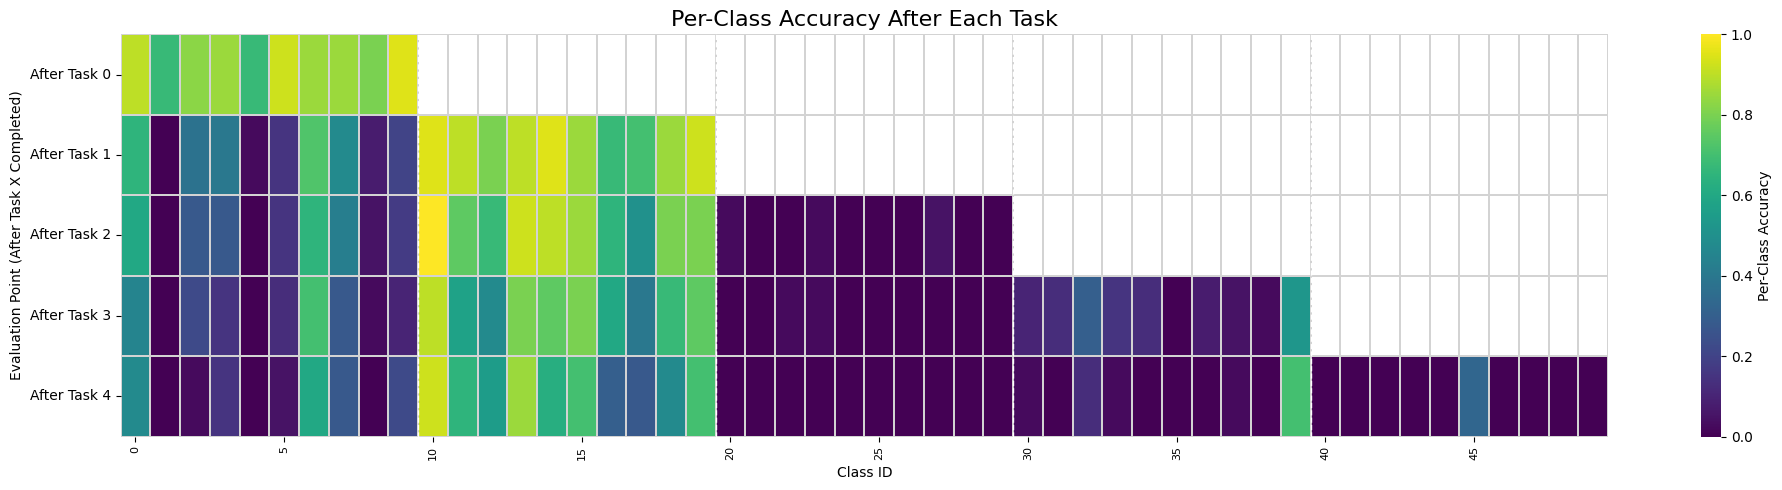

In [23]:
# texture dataset
accuracy_file_path = 'replay-ewc-coarse-grained/accuracies.txt' # Make sure this file exists
num_total_classes = 50
num_classes_per_task = 10

visualize_forgetting(accuracy_file_path, num_total_classes, num_classes_per_task)

Error: Accuracy file not found at 'accuracies.txt'
Please make sure you have saved the data into a file named 'accuracies.txt' in the correct directory.
Error: Accuracy file not found at 'accuracies.txt'
No valid task data parsed. Exiting.


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


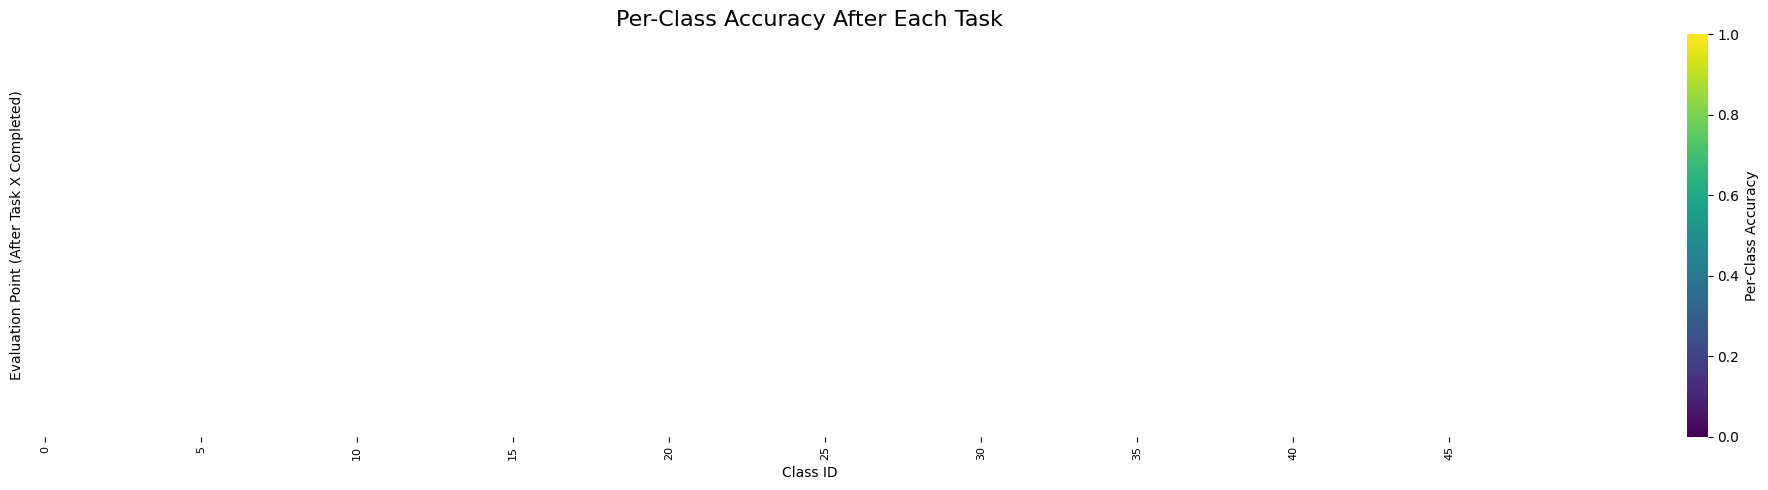

In [24]:
# the aircraft families
accuracy_file_path = 'accuracies.txt'
num_total_classes = 50
num_classes_per_task = 10

visualize_forgetting(accuracy_file_path, num_total_classes, num_classes_per_task)